In [32]:
import math
import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def computeMinPath(graph, numVertices):
  minPath = np.zeros((numVertices, 2))
  for i in range(numVertices):
    edgeWeights = graph[i]
    
    minEdge = np.min(edgeWeights)
    secondMinEdge = np.partition(edgeWeights, 1)[1]

    minPath[i] = [minEdge, secondMinEdge]

  return minPath
      
def getOnePath(graph, numVertices):
  path = np.array([0])
  cost = 0
  for i in range(1, numVertices):
    cost += graph[path[-1]][i]
    path = np.concatenate([path, [i]]).astype(int)
  cost += graph[path[-1]][0]
  path = np.concatenate([path, [0]]).astype(int)
  return path, cost

def bound(graph, minPath, nextVertice, prevNode=None):
  if prevNode is None:
    return np.sum(minPath) / 2
  
  cost = graph[prevNode.path[-1]][nextVertice]

  bound = prevNode.bound * 2

  if cost >= minPath[nextVertice][1]:
    bound -= minPath[nextVertice][1]
    bound += cost
  
  if cost >= minPath[prevNode.path[-1]][1]:
    bound -= minPath[prevNode.path[-1]][1]
    bound += cost

  return bound / 2


## Branch and Bound

In [17]:
class Node:
  def __init__(self, graph, minPath, prevNode=None, nextVertice=None):
    if prevNode is None or nextVertice is None:
      self.level = 1
      self.path = [0]
      self.cost = 0
      self.bound = bound(graph, minPath, 0)
      return

    self.level = prevNode.level + 1
    self.path = np.concatenate([prevNode.path, [nextVertice]]).astype(int)
    if len(prevNode.path) == 0:
      self.cost = 0
    else:
      self.cost = prevNode.cost + graph[prevNode.path[-1]][nextVertice]
    self.bound = bound(graph, minPath, nextVertice, prevNode)

  def __lt__(self, other):
    return self.bound < other.bound
  
  def __gt__(self, other):
    return self.bound > other.bound
  
  def __eq__(self, other):
    return self.bound == other.bound
  
  def __str__(self) -> str:
    return f"Path: {self.path} Cost: {self.cost} Bound: {self.bound}"

In [18]:
def branchAndBoundTSP(graph, numVertices, timeLimit=1800):
  startTime = time.time()

  minPath = computeMinPath(graph, numVertices)

  root = Node(graph, minPath, None, 0)
  stack = [root]

  solution = [] 
  best = np.inf

  while stack and time.time() - startTime < timeLimit:
    node = stack.pop()
    
    if node.level >= numVertices:
      finalNode = Node(graph, minPath, node, 0)
      if finalNode.cost < best:
        best = finalNode.cost
        solution = finalNode.path
    
    elif node.bound < best:
      unvisited = np.setdiff1d(np.arange(numVertices), node.path)
      for k in unvisited:
        newNode = Node(graph, minPath, node, k)
        if newNode.bound < best and graph[node.path[-1]][k] != np.inf:
          stack.append(newNode)

  return solution, best

## Twice Around the Tree

In [19]:
def generateMST(graph, numVertices):
  included = [False] * numVertices
  included[0] = True

  cost = 0
  edges = []
  numVisited = 1

  while numVisited < numVertices:
    minEdge = (float('inf'), None, None) 

    for i in range(numVertices):
      if included[i]:
        for j in range(numVertices):
          if not included[j] and graph[i][j] < minEdge[0]:
            minEdge = (graph[i][j], i, j)

    cost, startVertex, endVertex = minEdge
    included[endVertex] = True
    cost += cost
    edges.append((startVertex, endVertex))
    numVisited += 1

  mstAdjMatrix = np.full((numVertices, numVertices), np.inf)
  for edge in edges:
    mstAdjMatrix[edge[0]][edge[1]] = mstAdjMatrix[edge[1]][edge[0]] = graph[edge[0]][edge[1]]

  return mstAdjMatrix, cost

In [20]:
def preorderWalkAux(adjMatrix, startVertex, visited, order):
  order.append(startVertex)
  visited[startVertex] = True

  for neighbor in range(len(adjMatrix)):
    if adjMatrix[startVertex][neighbor] != np.inf and not visited[neighbor]:
      preorderWalkAux(adjMatrix, neighbor, visited, order)

def preorderWalk(adjMatrix, start_vertex=0):
  numVertices = len(adjMatrix)
  visited = [False] * numVertices
  order = []

  preorderWalkAux(adjMatrix, start_vertex, visited, order)

  return order

In [21]:
def approximateTwiceAroundTheTree(graph, numVertices):
  mstAdjMatrix, mstCost = generateMST(graph, numVertices)

  preorder = preorderWalk(mstAdjMatrix)
  tour = preorder + [preorder[0]]

  tourCost = sum(graph[tour[i]][tour[i + 1]] for i in range(len(tour) - 1))

  return tour, tourCost

## Christofides

In [22]:
def perfectMatching(graph, oddVertices):
  edges = []
  for i in oddVertices:
    for j in oddVertices:
      if i < j and graph[i][j] != np.inf:
        edges.append((i, j, graph[i][j]))

  edges.sort(key=lambda x: x[2])

  matching = []
  visited = np.zeros(len(graph), dtype=bool)

  for edge in edges:
    if not visited[edge[0]] and not visited[edge[1]]:
      matching.append((edge[0], edge[1]))
      visited[edge[0]] = True
      visited[edge[1]] = True

  return matching

In [23]:
def getEulerianCircuit(graph):
  startVertex = 0 
  numVertices = len(graph)
  visited = np.zeros(numVertices, dtype=bool)
  tour = []
  stack = np.array([startVertex])

  while stack.size > 0:
    vertex = stack[-1]
    if not visited[vertex]:
      visited[vertex] = True
      tour.append(vertex)
    unvisited_neighbors = np.where((graph[vertex] != np.inf) & (~visited))[0]
    if unvisited_neighbors.size > 0:
      next_vertex = unvisited_neighbors[0]
      stack = np.append(stack, next_vertex)
    else:
      stack = stack[:-1]

  return tour

In [24]:
def christofides(graph, numVertices):
  mstAdjMatrix, mstCost = generateMST(graph, numVertices)

  oddVertices = [vertex for vertex, degree in enumerate(np.sum(mstAdjMatrix != np.inf, axis=1)) if degree % 2 != 0]

  matchingEdges = perfectMatching(graph, oddVertices)

  multigraph = mstAdjMatrix.copy()
  for edge in matchingEdges:
    multigraph[edge[0]][edge[1]] = multigraph[edge[1]][edge[0]] = graph[edge[0]][edge[1]]

  eulerianCircuit = getEulerianCircuit(multigraph)
  hamiltonianCircuit = list(dict.fromkeys(eulerianCircuit))
  hamiltonianCircuit.append(hamiltonianCircuit[0])

  tourCost = sum(graph[hamiltonianCircuit[i]][hamiltonianCircuit[i + 1]] for i in range(len(hamiltonianCircuit) - 1))

  return hamiltonianCircuit, tourCost

## Reading input files

In [4]:
def readCoordinatesFromFile(filename):
  coordinates = []

  with open(filename, 'r') as file:
    for line in file:
      if "NODE_COORD_SECTION" in line:
        break

    for line in file:
      if line.strip() == "EOF":
        break
      id, x, y = map(float, line.split())
      coordinates.append((int(id)-1, x, y))

  return coordinates

def calculateEuclideanDistance(point1, point2):
    x1, y1 = point1[1], point1[2]
    x2, y2 = point2[1], point2[2]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def getGraphFromFile(filename):
    coordinates = readCoordinatesFromFile(filename)
    numPoints = len(coordinates)

    graph = np.full((numPoints, numPoints), np.inf)

    for i in range(numPoints):
      for j in range(i+1, numPoints):
        distance = calculateEuclideanDistance(coordinates[i], coordinates[j])
        graph[coordinates[i][0]][coordinates[j][0]] = graph[coordinates[j][0]][coordinates[i][0]] = distance

    return graph

In [5]:
def getFilesInFolder(folderPath):
  return [os.path.join(folderPath, file) for file in os.listdir(folderPath) if os.path.isfile(os.path.join(folderPath, file))]

files = getFilesInFolder("data")
files.sort()
print(files)

['data/u2152.tsp', 'data/u2319.tsp']


## Testing

In [27]:
numVertices = 4
graph = np.full((numVertices, numVertices), np.inf)
graph = np.array([
       [0, 10, 15, 20],
       [10, 0, 35, 25],
       [15, 35, 0, 30],
       [20, 25, 30, 0]
       ])
solution, best = branchAndBoundTSP(graph, numVertices)

print(f"Solution: {solution} Cost: {best}")

Solution: [0 2 3 1 0] Cost: 80


In [28]:
outputFolder = "out"
os.makedirs(outputFolder, exist_ok=True)

for file in files:
  graph = getGraphFromFile(file)
  numVertices = len(graph)

  fileNameWithoutExtension = os.path.splitext(os.path.basename(file))[0]
  outputFilename = os.path.join(outputFolder, f"results_{fileNameWithoutExtension}.txt")

  with open(outputFilename, "w") as outputFile:
    outputFile.write(f"---------- Dataset: {file} - Number of vertices: {numVertices} ----------\n")
    print(f"---------- Dataset: {file} - Number of vertices: {numVertices} ----------\n")

    # Branch and Bound
    # start_time = time.time()
    # solution, best = branchAndBoundTSP(graph, numVertices)
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Branch and Bound:")
    # print(f"Cost: {best}")
    # print(f"Solution: {solution}")
    # print(f"Elapsed Time: {elapsed_time} seconds\n")
    # outputFile.write("Branch and Bound:\n")
    # outputFile.write(f"Cost: {best}\n")
    # outputFile.write(f"Solution: {solution}\n")
    # outputFile.write(f"Elapsed Time: {elapsed_time} seconds\n\n")

    # Twice Around The Tree
    start_time = time.time()
    solution, best = approximateTwiceAroundTheTree(graph, numVertices)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Twice Around the Tree:")
    print(f"Cost: {best}")
    print(f"Solution: {solution}")
    print(f"Elapsed Time: {elapsed_time} seconds\n")
    outputFile.write("Twice Around the Tree:\n")
    outputFile.write(f"Cost: {best}\n")
    outputFile.write(f"Solution: {solution}\n")
    outputFile.write(f"Elapsed Time: {elapsed_time} seconds\n\n")

    # Christofides
    start_time = time.time()
    solution, best = christofides(graph, numVertices)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Christofides:")
    print(f"Cost: {best}")
    print(f"Solution: {solution}")
    print(f"Elapsed Time: {elapsed_time} seconds\n")
    outputFile.write("Christofides:\n")
    outputFile.write(f"Cost: {best}\n")
    outputFile.write(f"Solution: {solution}\n")
    outputFile.write(f"Elapsed Time: {elapsed_time} seconds\n\n")
    outputFile.write("----------------------------------------\n")

  print(f"Results for {file} saved to {outputFilename}\n")
  print("----------------------------------------\n")
  


---------- Dataset: data/u2152.tsp - Number of vertices: 2152 ----------

Twice Around the Tree:
Cost: 93393.44313861098
Solution: [0, 1, 3, 2, 2137, 2135, 2133, 2131, 2129, 2127, 2126, 2125, 2111, 2110, 2108, 2106, 2104, 2103, 2102, 2099, 2098, 2097, 2096, 356, 357, 359, 358, 363, 362, 365, 364, 366, 367, 361, 360, 2093, 2092, 2091, 2090, 2089, 2088, 2087, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 368, 369, 370, 371, 373, 372, 1765, 1764, 1763, 1766, 1768, 1767, 1778, 1777, 1770, 1769, 1776, 1775, 1772, 1771, 1774, 1773, 1789, 1786, 1788, 1787, 1688, 1687, 1685, 1683, 1681, 1680, 1679, 1677, 1659, 1660, 1658, 1657, 1656, 1655, 1654, 1651, 1650, 1648, 1647, 1646, 1644, 1643, 1642, 1838, 1837, 1836, 1824, 1825, 1815, 1814, 1813, 1812, 1811, 1810, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1645, 1649, 1652, 1653, 1663, 1662, 1661, 1678, 1682, 1797, 1796, 1795, 1794, 1793, 1792, 1791, 1790, 2078, 2077, 2076, 2075, 1801, 1800, 1799, 1798, 1684, 1686, 1690, 1689, 376, 377, 378, 379, 37

## Results

In [105]:
import re
import matplotlib.pyplot as plt

def extractInfo(filePath):
  with open(filePath, 'r') as file:
    content = file.read()

  numVertices = re.search(r'Number of vertices: (\d+)', content)
  costsMatch = re.findall(r'Cost: (.+)', content)
  timesMatch = re.findall(r'Elapsed Time: (.+) seconds', content)

  if not numVertices or not costsMatch or not timesMatch:
    return None, None, None

  numVertices = int(numVertices.group(1))
  costs = []
  for cost in costsMatch:
    cost = float(cost)
    costs.append(cost)
  times = []
  for time in timesMatch:
    time = float(time)
    times.append(time)

  if len(costs) < 3 or len(times) < 3:
    costs.insert(0, 0)
    times.insert(0, 0)

  return numVertices, costs, times

# Extract info from files
files = getFilesInFolder('./out')
files.sort()
datasetsPaths = []
results = []
for file in files:
  numVertices, costs, times = extractInfo(file)
  if numVertices and costs and times:
    results.append((numVertices, costs, times))
    datasetsPaths.append(file)


In [106]:
datasetsNames = []
for i, dataset in enumerate(datasetsPaths):
  datasetsNames.append((i, os.path.splitext(os.path.basename(dataset))[0])) 
  
print(datasetsNames)

[(0, 'results_ch130'), (1, 'results_ch150'), (2, 'results_d1291'), (3, 'results_d1655'), (4, 'results_d198'), (5, 'results_d2103'), (6, 'results_d493'), (7, 'results_d657'), (8, 'results_eil101'), (9, 'results_eil51'), (10, 'results_eil76'), (11, 'results_fl1400'), (12, 'results_fl1577'), (13, 'results_fl3795'), (14, 'results_fl417'), (15, 'results_fnl4461'), (16, 'results_gil262'), (17, 'results_kroA100'), (18, 'results_kroA150'), (19, 'results_kroA200'), (20, 'results_kroB100'), (21, 'results_kroB150'), (22, 'results_kroB200'), (23, 'results_kroC100'), (24, 'results_kroD100'), (25, 'results_kroE100'), (26, 'results_lin318'), (27, 'results_linhp318'), (28, 'results_nrw1379'), (29, 'results_p654'), (30, 'results_pcb1173'), (31, 'results_pcb3038'), (32, 'results_pcb442'), (33, 'results_pr1002'), (34, 'results_pr107'), (35, 'results_pr124'), (36, 'results_pr136'), (37, 'results_rat195'), (38, 'results_rat575'), (39, 'results_rat783'), (40, 'results_rd100'), (41, 'results_rd400'), (42, 'r

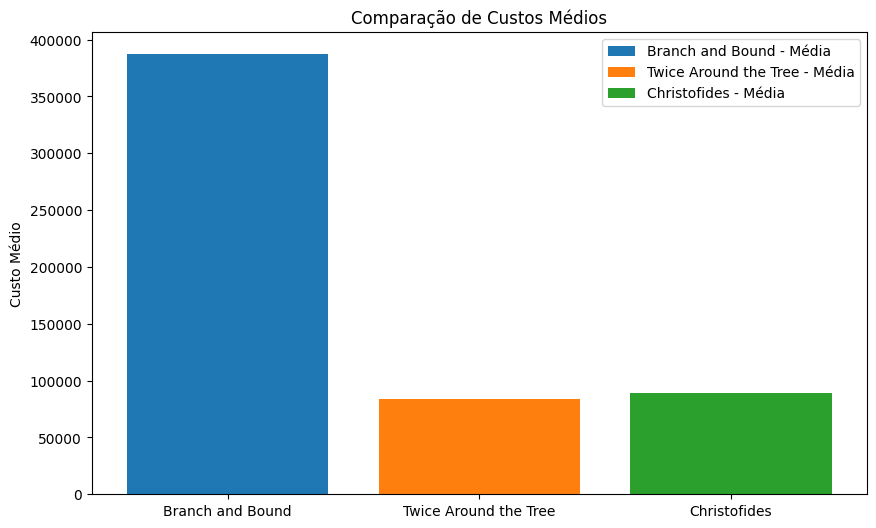

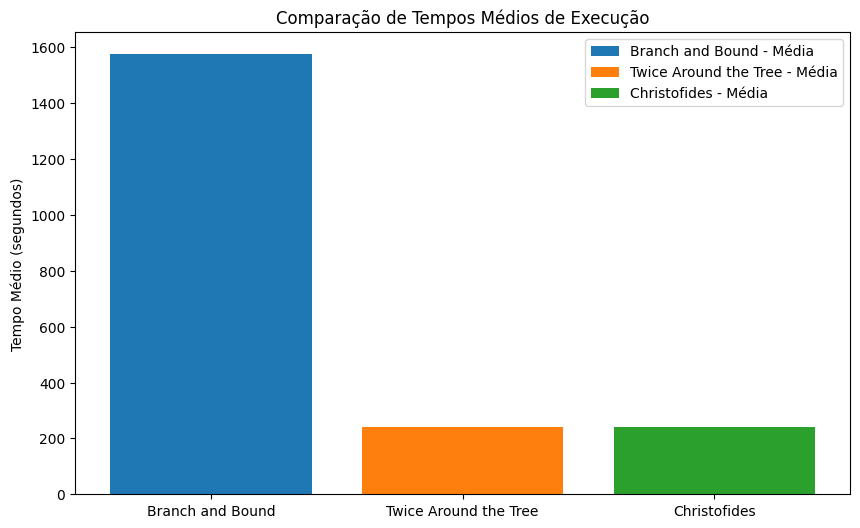

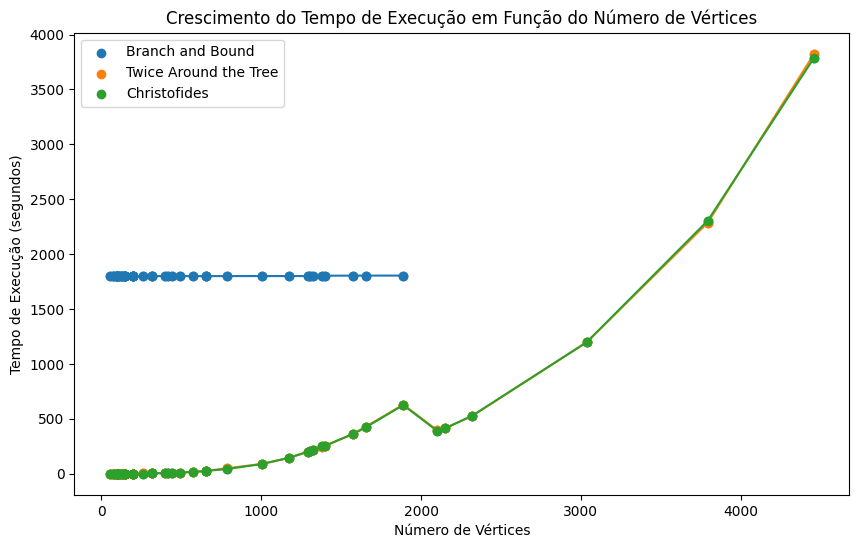

In [114]:
num_vertices, costs, times = zip(*results)

algorithms = ['Branch and Bound', 'Twice Around the Tree', 'Christofides']

# Plotar gráficos de barra para custos médios
fig, ax1 = plt.subplots(figsize=(10, 6))

for i, algorithm in enumerate(algorithms):
  cost_values = [cost[i] for cost in costs]
  mean_cost = np.mean(cost_values)
  ax1.bar(algorithm, mean_cost, label=f'{algorithm} - Média')

ax1.set_title('Comparação de Custos Médios')
ax1.set_ylabel('Custo Médio')

ax1.legend()
plt.show()

# Plotar gráficos de barra para tempos médios
fig, ax2 = plt.subplots(figsize=(10, 6))

for i, algorithm in enumerate(algorithms):
  time_values = [time[i] for time in times]
  mean_time = np.mean(time_values)
  ax2.bar(algorithm, mean_time, label=f'{algorithm} - Média')

ax2.set_title('Comparação de Tempos Médios de Execução')
ax2.set_ylabel('Tempo Médio (segundos)')

ax2.legend()
plt.show()

# Plotar gráfico de dispersão para tempo de execução vs. número de vértices
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(algorithms):
    # Obtém os valores ordenados por num_vertices
    sorted_indices = np.argsort(num_vertices)
    sorted_num_vertices = np.array(num_vertices)[sorted_indices]
    sortedTimeValues = np.array([time[i] for time in times])[sorted_indices]

    # Encontra índices onde o tempo é maior que zero
    non_zero_indices = sortedTimeValues > 0

    # Plota os pontos apenas para tempos maiores que zero
    plt.scatter(sorted_num_vertices[non_zero_indices], sortedTimeValues[non_zero_indices], label=algorithm)

    # Plota a curva apenas para tempos maiores que zero
    plt.plot(sorted_num_vertices[non_zero_indices], sortedTimeValues[non_zero_indices], marker='o', linestyle='-')

plt.title('Crescimento do Tempo de Execução em Função do Número de Vértices')
plt.xlabel('Número de Vértices')
plt.ylabel('Tempo de Execução (segundos)')

plt.legend()
plt.show()


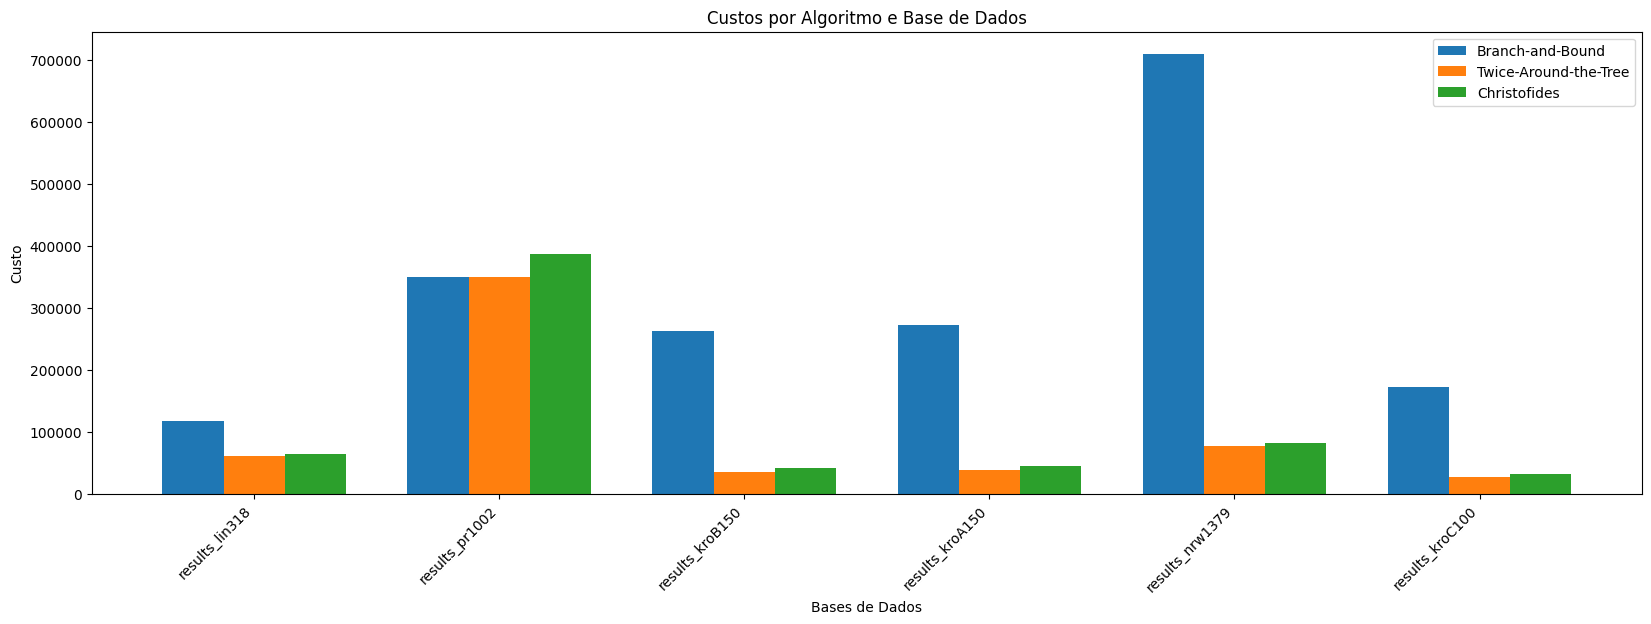

In [108]:
datasetsEscolhidos = random.sample(datasetsNames, 15)
datasetsIndexes = [elements[0] for elements in datasetsEscolhidos]
datasetsEscolhidos = [elements[1] for elements in datasetsEscolhidos]

algoritmos = ['Branch-and-Bound', 'Twice-Around-the-Tree', 'Christofides']

custos = []
indicesAExcluir = []
for i, index in enumerate(datasetsIndexes):
  if costs[index][0] < 3000000 and costs[index][0] > 100000:
    custos.append([costs[index][0], costs[index][1], costs[index][2]])
  else:
    indicesAExcluir.append(i)
custos = np.array(custos)

for indice in reversed(indicesAExcluir):
  del datasetsEscolhidos[indice]


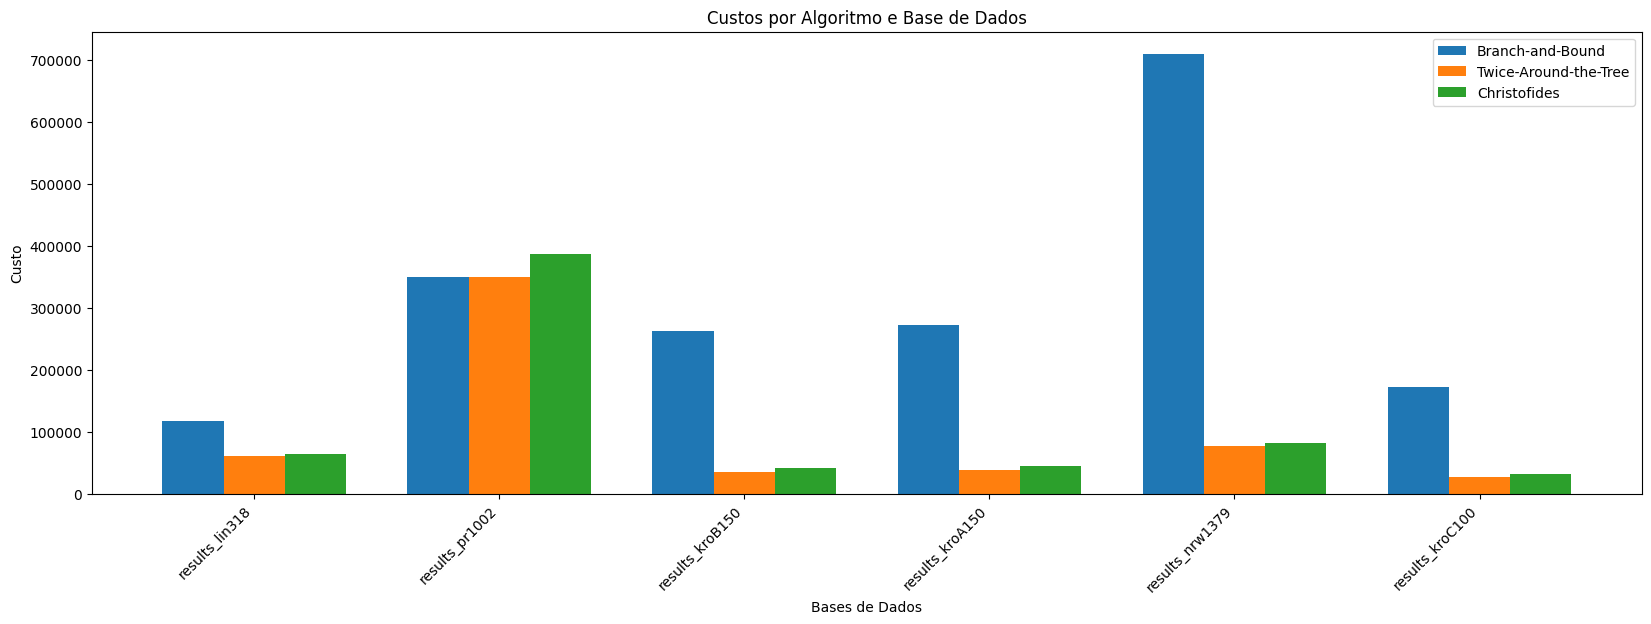

In [110]:
fig, ax = plt.subplots(figsize=(20, 6))

# Configurar o gráfico
bar_width = 0.25
index = np.arange(len(datasetsEscolhidos))

# Criar barras para cada algoritmo
for i, algoritmo in enumerate(algoritmos):
  plt.bar(index + i * bar_width, custos[:, i], bar_width, label=algoritmo)

# Adicionar rótulos e legendas
plt.xlabel('Bases de Dados')
plt.ylabel('Custo')
plt.title('Custos por Algoritmo e Base de Dados')
plt.xticks(index + bar_width * (len(algoritmos) - 1) / 2, datasetsEscolhidos, rotation=45, ha='right')
plt.legend()

# Exibir o gráfico
plt.show()

In [113]:
# find the index of the dataset 'results_pr1002'
pr1002_index = datasetsEscolhidos.index('results_pr1002')
print(pr1002_index)
print(datasetsIndexes[pr1002_index])
print(costs[44])

1
44
[6589716.120061919, 454996.97915850556, 495369.90329080453]


In [12]:
print(costs)
costs = np.array(costs)

normalizedCosts = [arr / max(arr) for arr in costs]

print(normalizedCosts)

([44637.2297306206, 8276.508282188533, 9230.694592156156], [49424.05460307776, 9202.462633963576, 9109.105236956155], [150990.3956598183, 74433.77699056764, 74960.04737355495], [205956.226516653, 86333.62993326763, 94527.52228152053], [22366.817047469416, 19160.014757133264, 19495.656837712693], [113466.96567196748, 46216.84895669126, 47015.22139106686], [232123.32334046793, 65857.40569625125, 67731.24125064474], [1923.1996850955236, 886.1115549507533, 946.7688306813619], [1208.454024763653, 623.9475873228789, 524.9709794695316], [1870.190259886142, 749.2749518743223, 736.8101114146029], [170586.3376289605, 29280.449948363927, 32232.051035029297], [51065.313439708334, 31192.52338700186, 33029.440306785174], [54693.9401213582, 16189.205654810286, 19242.464439585034], [25833.60550669745, 3340.8434989496354, 3777.4128690968423], [174744.72319297743, 30516.94176196444, 37552.46971977364], [272050.37211122643, 38762.59179345835, 44761.50332226895], [363743.42773337977, 40235.25362345715, 46

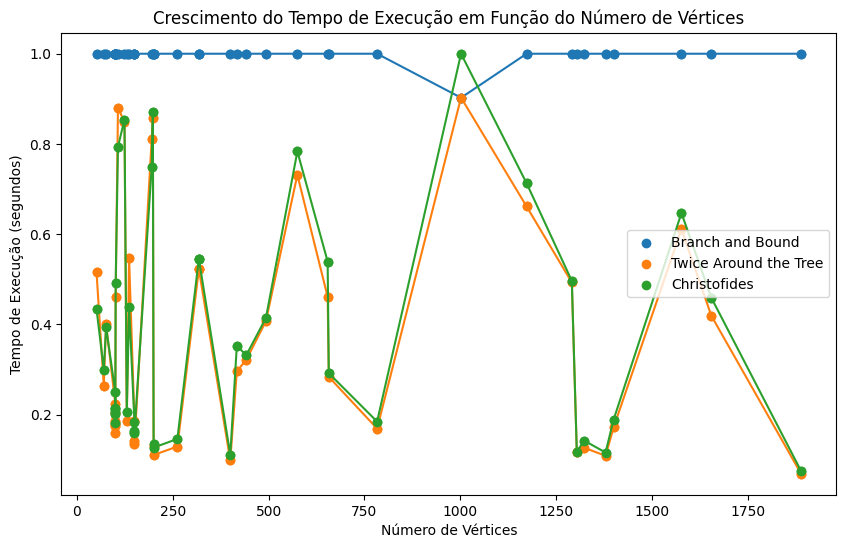

In [13]:
# Plotar gráfico de dispersão para tempo de execução vs. número de vértices
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(algorithms):
  # Obtém os valores ordenados por num_vertices
  sorted_indices = np.argsort(num_vertices)
  sorted_num_vertices = np.array(num_vertices)[sorted_indices]
  sortedCostValues = np.array([cost[i] for cost in normalizedCosts])[sorted_indices]

  # Plota os pontos da mesma cor
  plt.scatter(sorted_num_vertices, sortedCostValues, label=algorithm)

  # Plota a curva
  plt.plot(sorted_num_vertices, sortedCostValues, marker='o', linestyle='-')

plt.title('Crescimento do Tempo de Execução em Função do Número de Vértices')
plt.xlabel('Número de Vértices')
plt.ylabel('Tempo de Execução (segundos)')

plt.legend()
plt.show()